In [1]:
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import shap
from sklearn.utils import resample
from adjustText import adjust_text

In [2]:
RANDOM_STATE = 42

def set_random_seeds(seed_value=RANDOM_STATE):
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_random_seeds()

## Data Extraction

In [3]:
# Querying Gaia Data
def query_gaia_data(coord, width, height):
    query = f"""
    SELECT * FROM gaiadr3.gaia_source
    WHERE CONTAINS(POINT('ICRS',ra,dec), BOX('ICRS',{coord.ra.degree},{coord.dec.degree},{width.value},{height.value}))=1
    """
    job = Gaia.launch_job_async(query, dump_to_file=True)
    r = job.get_results()
    df = r.to_pandas()
    print(df[['parallax', 'phot_g_mean_mag']].describe())
    df = df[df['parallax'] > 0]
    df['distance'] = 1000 / df['parallax']
    df['absolute_magnitude'] = df['phot_g_mean_mag'] - 5 * (np.log10(df['distance']) - 1)
    df.dropna(subset=['absolute_magnitude', 'distance'], inplace=True)
    return df

# Defining coordinates for querying Gaia data
coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.1, u.deg)
height = u.Quantity(0.1, u.deg)
df = query_gaia_data(coord, width, height)
df

         parallax  phot_g_mean_mag
count  171.000000       184.000000
mean     0.448581        19.065098
std      0.889585         1.751025
min     -3.228147        11.302683
25%      0.139302        18.236661
50%      0.386419        19.467603
75%      0.751901        20.393923
max      3.644433        21.578821


,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,distance,absolute_magnitude
0,1636148068921376768,Gaia DR3 6636070169946659712,6636070169946659712,1549774393,2016.0,279.950150,0.040951,-59.965110,0.042149,0.729914,...,0.1595,0.0982,0.0716,0.1250,0.0516,0.0376,0.0656,MARCS,1370.023884,6.249249
1,1636148068921376768,Gaia DR3 6636066935832385280,6636066935832385280,754604031,2016.0,279.950425,0.115976,-60.002444,0.126472,1.583483,...,0.9668,0.5741,0.5346,0.6215,0.3718,0.3473,0.4009,MARCS,631.519130,9.513635
2,1636148068921376768,Gaia DR3 6636066832753162496,6636066832753162496,1366878663,2016.0,279.950527,0.145435,-60.017340,0.146777,0.207750,...,0.3405,0.0510,0.0086,0.2740,0.0274,0.0046,0.1463,PHOENIX,4813.471112,4.125420
3,1636148068921376768,Gaia DR3 6636066076838914304,6636066076838914304,891149282,2016.0,279.954885,0.070668,-60.027231,0.071029,0.275622,...,0.0380,0.0119,0.0030,0.0318,0.0065,0.0016,0.0173,MARCS,3628.154527,5.044215
5,1636148068921376768,Gaia DR3 6636070165653491328,6636070165653491328,79824548,2016.0,279.956998,0.226789,-59.953716,0.221995,0.968905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1032.092445,9.493251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1636148068921376768,Gaia DR3 6636089342680637568,6636089342680637568,795774845,2016.0,280.048529,0.043698,-60.020987,0.043506,0.750228,...,0.1729,0.1143,0.0954,0.1335,0.0599,0.0500,0.0700,PHOENIX,1332.928850,6.232899
180,1636148068921376768,Gaia DR3 6636089342676817920,6636089342676817920,298036207,2016.0,280.048836,0.109825,-60.012045,0.113158,0.119645,...,0.0090,0.0020,0.0003,0.0070,0.0011,0.0002,0.0038,MARCS,8358.063879,3.964718
181,1636148068921376768,Gaia DR3 6636089544540232832,6636089544540232832,312916707,2016.0,280.049071,0.163553,-60.003540,0.166458,0.711737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1405.013587,8.420102
182,1636148068921376768,Gaia DR3 6633086851303261824,6633086851303261824,609919212,2016.0,280.049260,0.063144,-60.044506,0.064215,0.202150,...,0.0441,0.0141,0.0033,0.0365,0.0076,0.0018,0.0199,MARCS,4946.817418,4.088317


## Exploratory Data Analysis

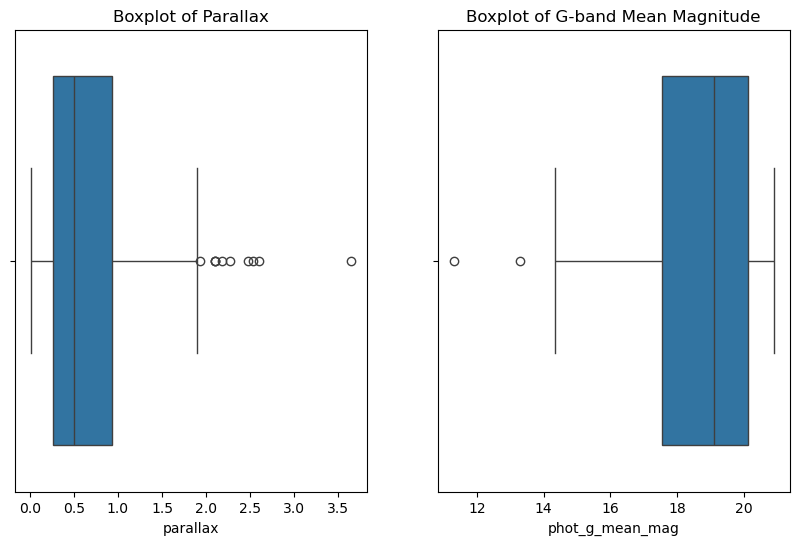

In [4]:
# Visualizing outliers in parallax and G-band mean magnitude
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['parallax'])
plt.title('Boxplot of Parallax')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['phot_g_mean_mag'])
plt.title('Boxplot of G-band Mean Magnitude')
plt.show()

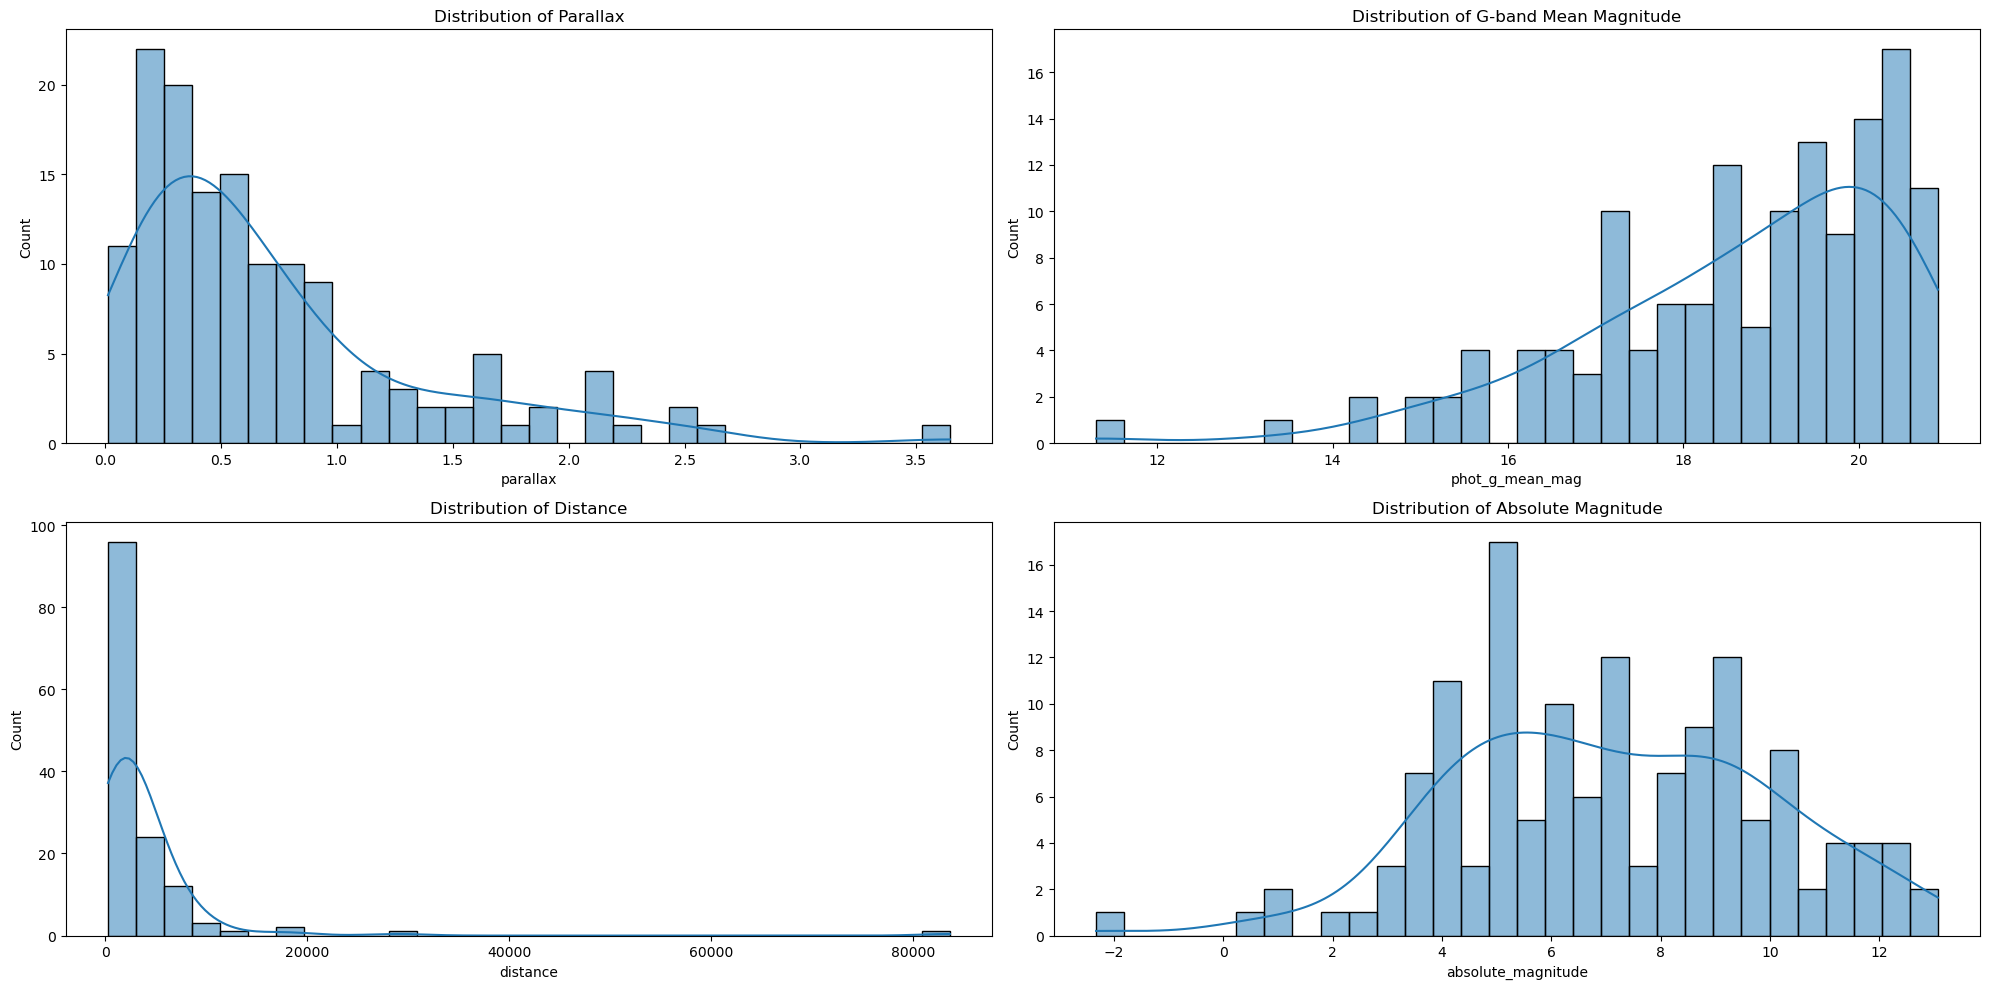

In [5]:
plt.figure(figsize=(20, 10))

# Parallax Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['parallax'], bins=30, kde=True)
plt.title('Distribution of Parallax')

# Phot G Mean Mag Distribution
plt.subplot(2, 2, 2)
sns.histplot(df['phot_g_mean_mag'], bins=30, kde=True)
plt.title('Distribution of G-band Mean Magnitude')

# Distance Distribution
plt.subplot(2, 2, 3)
sns.histplot(df['distance'], bins=30, kde=True)
plt.title('Distribution of Distance')

# Absolute Magnitude Distribution
plt.subplot(2, 2, 4)
sns.histplot(df['absolute_magnitude'], bins=30, kde=True)
plt.title('Distribution of Absolute Magnitude')

plt.tight_layout()
plt.show()

## Data Preprocessing

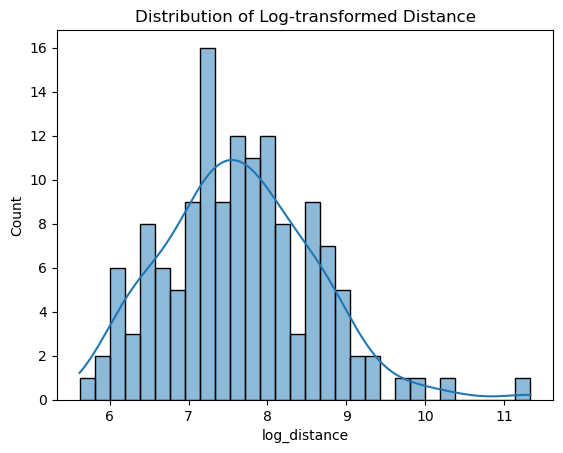

In [6]:
# Applying log transformation to 'distance'
df['log_distance'] = np.log1p(df['distance'])

sns.histplot(df['log_distance'], bins=30, kde=True)
plt.title('Distribution of Log-transformed Distance')
plt.show()

In [ ]:
# Removing outliers using the IQR method
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [7]:
def preprocess_data(df):
    df = df[df['parallax'] > 0]
    df = remove_outliers(df, 'parallax')
    df = remove_outliers(df, 'phot_g_mean_mag')
    df = df[df['distance'] > 0]
    df.dropna(subset=['parallax', 'phot_g_mean_mag', 'distance', 'absolute_magnitude'], inplace=True)
    df['log_distance'] = np.log1p(df['distance'])
    selected_features = [
        'log_distance', 'phot_g_mean_mag', 'bp_rp', 'phot_bp_mean_mag',
        'phot_rp_mean_mag', 'ruwe', 'astrometric_excess_noise',
        'phot_g_mean_flux_over_error', 'phot_bp_rp_excess_factor',
        'parallax_over_error', 'visibility_periods_used', 'astrometric_sigma5d_max'
    ]
    df_selected = df[selected_features + ['absolute_magnitude']].copy()
    simple_imputer = SimpleImputer(strategy='median')
    cols_with_minimal_missing = ['bp_rp', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor']
    df_selected[cols_with_minimal_missing] = simple_imputer.fit_transform(df_selected[cols_with_minimal_missing])
    return df, df_selected

df_cleaned, df_selected = preprocess_data(df)

print(df[['parallax', 'phot_g_mean_mag', 'distance', 'absolute_magnitude']].describe())

         parallax  phot_g_mean_mag      distance  absolute_magnitude
count  140.000000       140.000000    140.000000          140.000000
mean     0.712656        18.661934   3669.973865            7.073931
std      0.643395         1.784839   7716.198738            2.878884
min      0.011955        11.302683    274.391108           -2.331251
25%      0.267477        17.554388   1075.961590            4.956596
50%      0.504256        19.105657   1983.124591            6.931961
75%      0.929435        20.118281   3738.635492            9.179454
max      3.644433        20.901760  83643.583141           13.068484


In [8]:
# Scaling Features
def scale_features(df, selected_features):
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[selected_features]), columns=selected_features)
    df_scaled['absolute_magnitude'] = df['absolute_magnitude'].values
    return df_scaled

selected_features = [
    'log_distance', 'phot_g_mean_mag', 'bp_rp', 'phot_bp_mean_mag',
    'phot_rp_mean_mag', 'ruwe', 'astrometric_excess_noise',
    'phot_g_mean_flux_over_error', 'phot_bp_rp_excess_factor',
    'parallax_over_error', 'visibility_periods_used', 'astrometric_sigma5d_max'
]

df_scaled = scale_features(df_selected, selected_features)
df_scaled

,log_distance,phot_g_mean_mag,bp_rp,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,astrometric_excess_noise,phot_g_mean_flux_over_error,phot_bp_rp_excess_factor,parallax_over_error,visibility_periods_used,astrometric_sigma5d_max,absolute_magnitude
0,-0.621702,-1.087205,-0.270099,-1.042258,-1.114289,-0.241672,-0.443037,0.742609,-0.445980,0.544707,0.622590,-0.678712,6.249249
1,-1.507131,-0.096658,2.885269,0.473280,-0.399250,-0.076136,-0.137210,-0.266225,1.130208,0.283150,0.150154,-0.408628,9.513635
2,0.815933,-0.708666,-0.487392,-0.774213,-0.733535,10.287605,1.537539,-0.610695,0.235007,-0.373661,0.150154,-0.352818,4.125420
3,0.492452,-0.517819,-1.000548,-0.629737,-0.398424,-0.055401,-0.390010,0.094651,-0.573220,-0.233764,0.150154,-0.582954,5.044215
4,-0.945612,0.558172,0.404637,0.544119,0.496091,-0.094279,-0.443037,-0.523178,0.643943,-0.188518,0.150154,-0.109143,9.493251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,-0.653097,-1.134743,-0.085018,-1.056679,-1.191639,0.309186,-0.215728,0.747315,-0.380445,0.542480,0.622590,-0.673912,6.232899
125,1.447406,-0.059307,-0.328113,-0.113929,-0.023392,0.085827,-0.443037,-0.255154,-0.218898,-0.391435,0.622590,-0.462058,3.964718
126,-0.592859,0.305735,2.058774,0.667290,0.095816,-0.206031,-0.443037,-0.421405,0.754955,-0.195827,0.150154,-0.284890,8.420102
127,0.847203,-0.694751,-0.860059,-0.761396,-0.596515,0.341362,-0.089838,0.183218,-0.715770,-0.267705,0.622590,-0.609647,4.088317


In [9]:
# Cross-Validation Metrics
def cross_val_metrics(model, X, y, cv):
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    mse_scores = cross_val_score(model, X, y, cv=cv, scoring=mse_scorer, n_jobs=-1)
    mae_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer, n_jobs=-1)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer, n_jobs=-1)

    return {
        'cv_rmse': np.sqrt(-mse_scores.mean()),
        'cv_mae': -mae_scores.mean(),
        'cv_r2': r2_scores.mean()
    }

## Model Training and Evaluation

In [10]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    models = {
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE),
        'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE),
        'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
        'NeuralNetwork': MLPRegressor(random_state=RANDOM_STATE),
        'SupportVectorRegressor': SVR(),
        'KNeighbors': KNeighborsRegressor()
    }

    param_grids = {
        'XGBoost': {
            'max_depth': [3, 4, 5],
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300]
        },
        'RandomForest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        },
        'GradientBoosting': {
            'n_estimators': [100, 200, 300, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.6, 0.8, 1.0],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'NeuralNetwork': {
            'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 50)],
            'activation': ['tanh', 'relu'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'alpha': [0.0001, 0.001, 0.01],
            'max_iter': [500, 1000, 1500]
        },
        'SupportVectorRegressor': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
        },
        'KNeighbors': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name} model ...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=kf, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        results[model_name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred),
            **cross_val_metrics(best_model, X_train, y_train, kf)
        }
        print(f"{model_name} - RMSE: {results[model_name]['rmse']:.4f}, MAE: {results[model_name]['mae']:.4f}, R: {results[model_name]['r2']:.4f}")
        print(f"{model_name} - CV RMSE: {results[model_name]['cv_rmse']:.4f}, CV MAE: {results[model_name]['cv_mae']:.4f}, CV R: {results[model_name]['cv_r2']:.4f}")

    return results

# Preparing data for modeling
X = df_scaled.drop('absolute_magnitude', axis=1)
y = df_scaled['absolute_magnitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

Training and evaluating XGBoost model ...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
XGBoost - RMSE: 0.4761, MAE: 0.3433, R: 0.9676
XGBoost - CV RMSE: 0.6558, CV MAE: 0.3989, CV R: 0.9377
Training and evaluating RandomForest model ...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForest - RMSE: 0.5648, MAE: 0.3165, R: 0.9545
RandomForest - CV RMSE: 0.7895, CV MAE: 0.5166, CV R: 0.9074
Training and evaluating GradientBoosting model ...
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
GradientBoosting - RMSE: 0.4691, MAE: 0.2806, R: 0.9686
GradientBoosting - CV RMSE: 0.5179, CV MAE: 0.3236, CV R: 0.9620
Training and evaluating NeuralNetwork model ...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
NeuralNetwork - RMSE: 0.1642, MAE: 0.1179, R: 0.9962
NeuralNetwork - CV RMSE: 0.3122, CV MAE: 0.1904, CV R: 0.9832
Training and evaluating SupportVectorRegressor model ...
Fitting 5 folds for each of 72 candidates, t

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

<Figure size 1200x600 with 0 Axes>

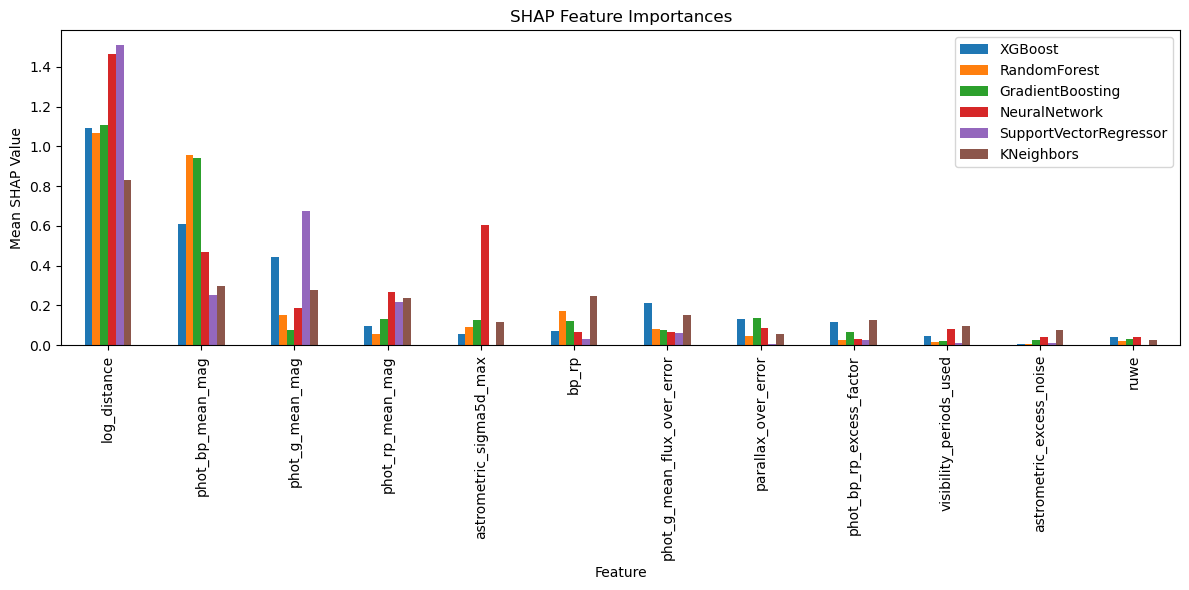

In [11]:
# SHAP Analysis for Feature Importances
def shap_analysis(model, X_train, X_test):
    if isinstance(model, (xgb.XGBRegressor, RandomForestRegressor)):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
    
    shap_values = explainer.shap_values(X_test)
    return shap_values

def compare_feature_importances(results, X_train, X_test):
    shap_values_dict = {}
    for model_name, metrics in results.items():
        shap_values_dict[model_name] = shap_analysis(metrics['model'], X_train, X_test)
    
    feature_importances = {model_name: np.abs(shap_values).mean(axis=0) 
                           for model_name, shap_values in shap_values_dict.items()}
    
    shap_df = pd.DataFrame({
        'Feature': X_test.columns,
        **feature_importances
    })
    
    shap_df['Mean_SHAP'] = shap_df.drop(columns=['Feature']).mean(axis=1)
    shap_df = shap_df.sort_values(by='Mean_SHAP', ascending=False)
    
    plt.figure(figsize=(12, 6))
    shap_df.plot(kind='bar', x='Feature', y=shap_df.columns[1:-1], figsize=(12, 6))
    plt.title('SHAP Feature Importances')
    plt.ylabel('Mean SHAP Value')
    plt.tight_layout()
    plt.show()
    
    return shap_df

shap_df = compare_feature_importances(results, X_train, X_test)

## Statistical Analysis of SVR: The Best Model  

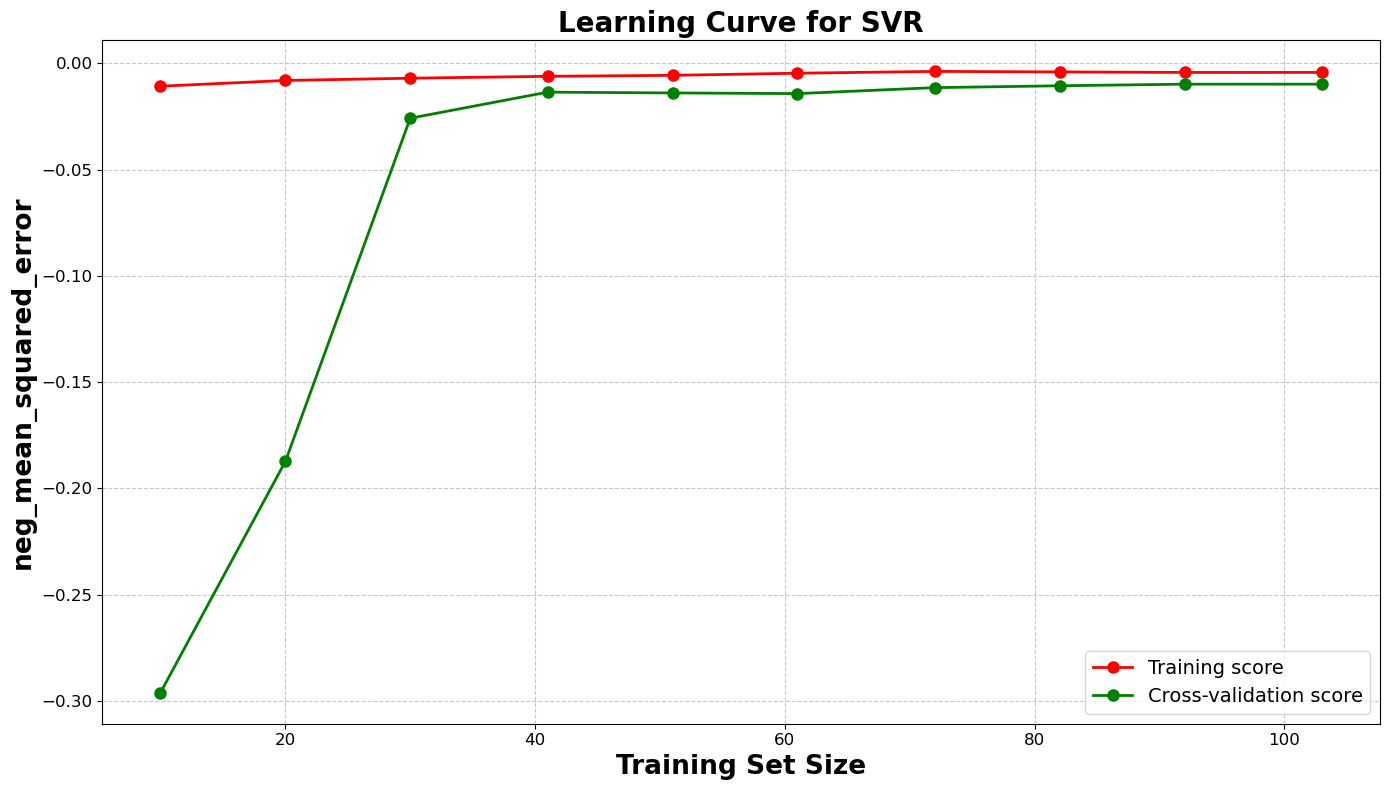

In [12]:
# Plotting Learning Curve
def plot_learning_curve(estimator, X, y, cv, scoring):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(14, 8))  
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score", linewidth=2, markersize=8)
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score", linewidth=2, markersize=8)
    
    plt.xlabel("Training Set Size", fontsize=19, fontweight='bold')
    plt.ylabel(scoring, fontsize=19, fontweight='bold')
    plt.title(f"Learning Curve for {type(estimator).__name__}", fontsize=20, fontweight='bold')
    
    plt.legend(loc="best", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    
    plt.show()

best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
plot_learning_curve(best_model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='neg_mean_squared_error')

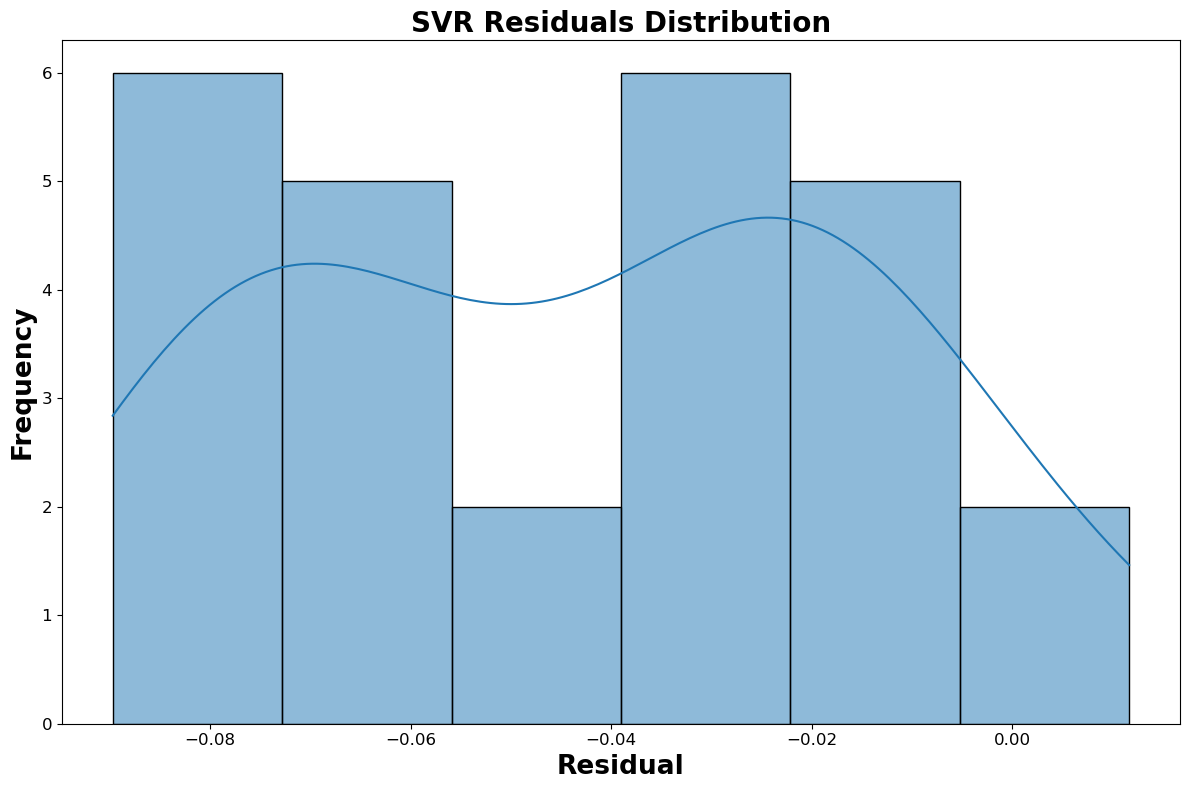

In [13]:
best_model = results['SupportVectorRegressor']['model']

# Error Distribution Analysis
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True)

plt.title("SVR Residuals Distribution", fontsize=20, fontweight='bold')
plt.xlabel("Residual", fontsize=19, fontweight='bold')
plt.ylabel("Frequency", fontsize=19, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

## Detailed SHAP Analysis for SVR


SupportVectorRegressor Model Metrics:
Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
RMSE: 0.0526
MAE: 0.0446
R²: 0.9996
Cross-Validation RMSE: 0.0954
Cross-Validation MAE: 0.0648
Cross-Validation R²: 0.9985


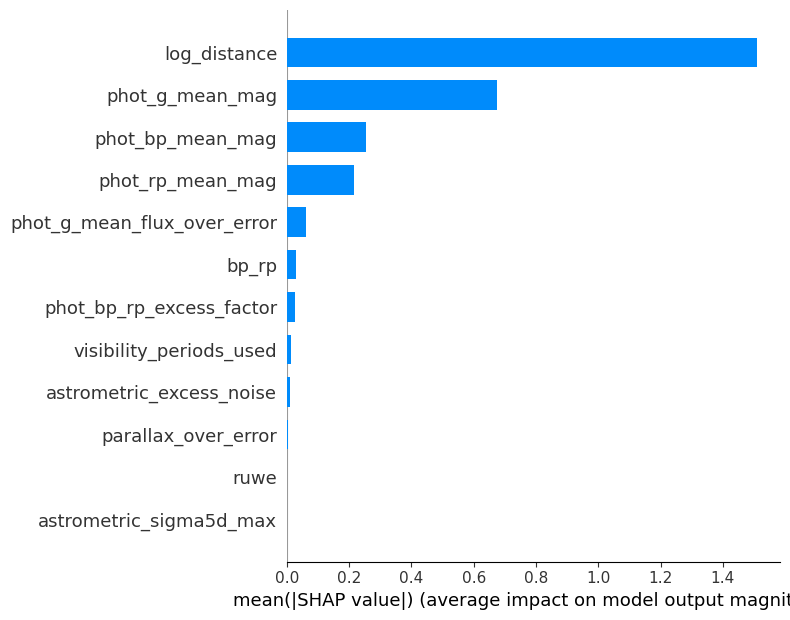


Feature importance:
                        Feature  Importance
0                  log_distance    1.507608
1               phot_g_mean_mag    0.674897
3              phot_bp_mean_mag    0.253633
4              phot_rp_mean_mag    0.215819
7   phot_g_mean_flux_over_error    0.062757
2                         bp_rp    0.029759
8      phot_bp_rp_excess_factor    0.026337
10      visibility_periods_used    0.012091
6      astrometric_excess_noise    0.010241
9           parallax_over_error    0.004650
5                          ruwe    0.000912
11      astrometric_sigma5d_max    0.000038


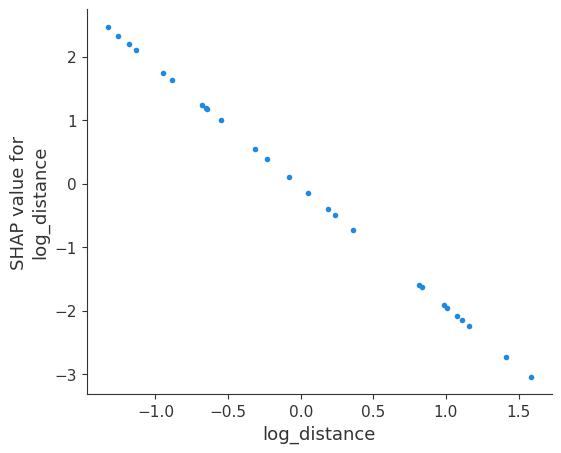

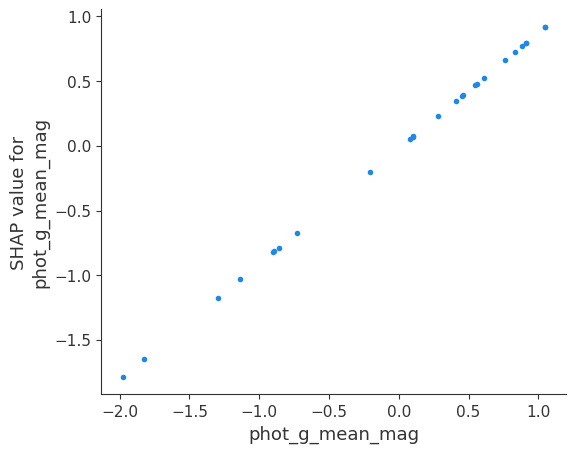

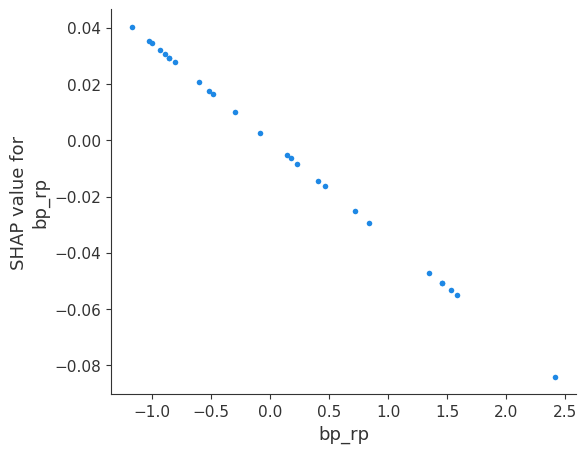

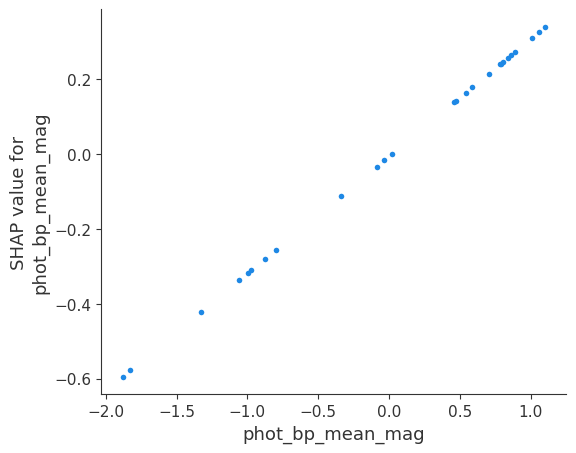

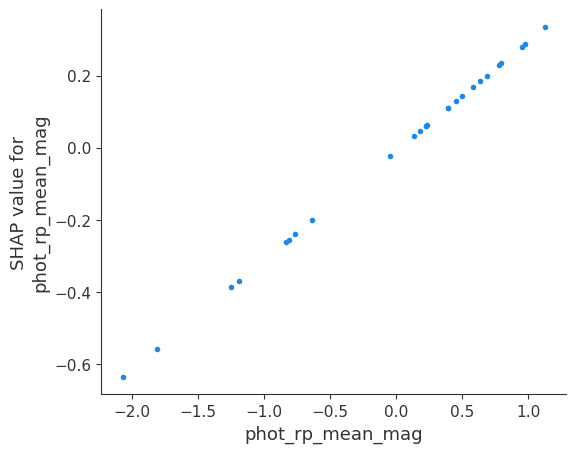

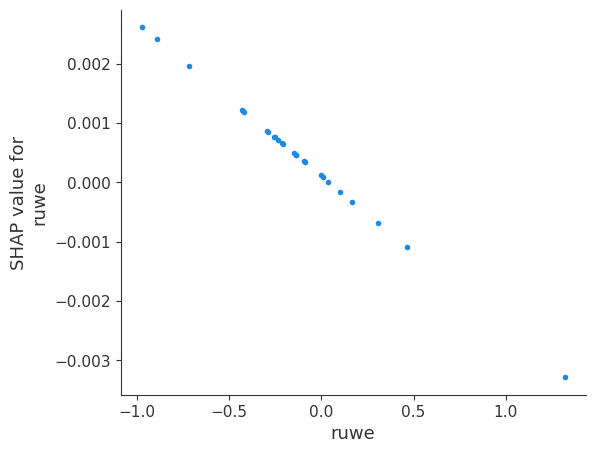

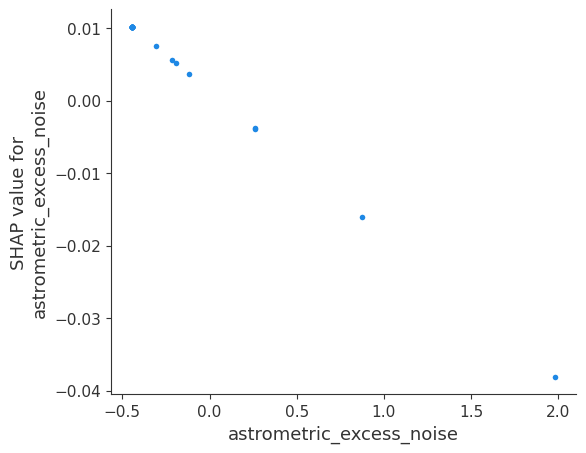

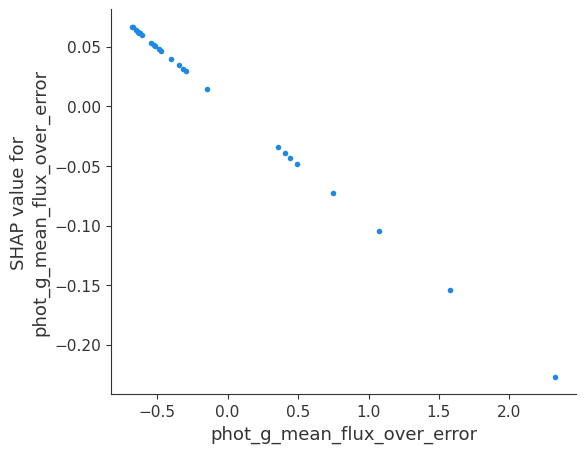

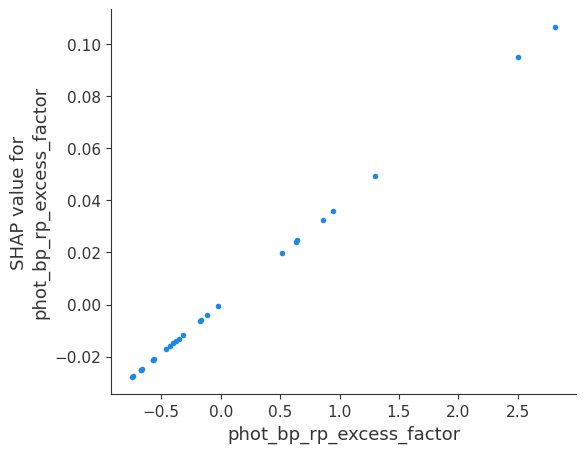

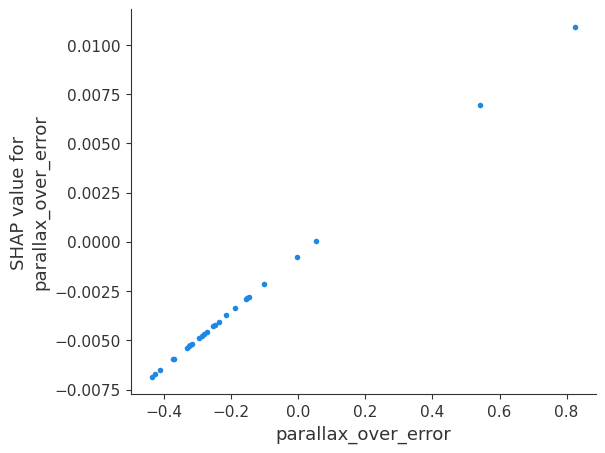

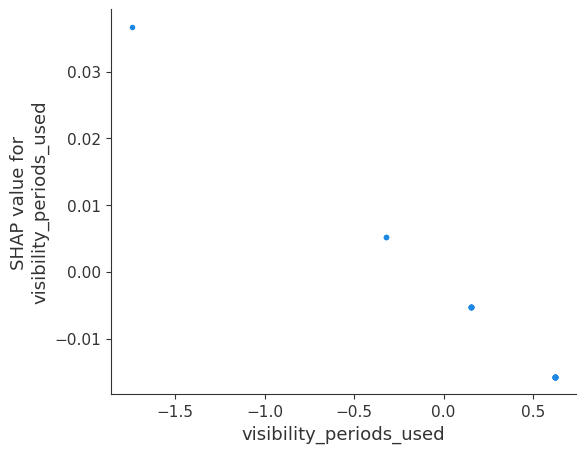

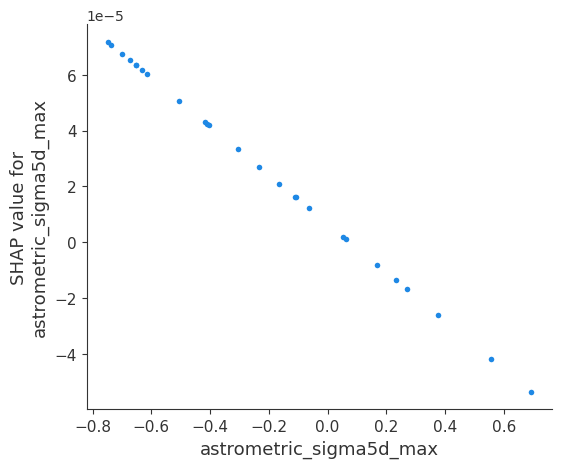

In [14]:
def detailed_shap_analysis(model, X_train, X_test, model_name):
    try:
        explainer = shap.Explainer(model, X_train)
    except Exception as e:
        print(f"Using KernelExplainer for {model_name} due to error: {e}")
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
    
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot (bar)
    shap.summary_plot(shap_values, X_test, plot_type="bar", 
                      title=f"SHAP Values for {model_name}")
    
    # Feature importance
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(X_test.columns, mean_shap_values)), 
                                      columns=['Feature', 'Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    print("\nFeature importance:")
    print(feature_importance)
    
    # Dependence plots
    for feature in X_test.columns:
        shap.dependence_plot(feature, shap_values, X_test, interaction_index=None)
    
    return shap_values

model_name = "SupportVectorRegressor"
if model_name in results:
    metrics = results[model_name]
    print(f"\n{model_name} Model Metrics:")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"Cross-Validation RMSE: {metrics['cv_rmse']:.4f}")
    print(f"Cross-Validation MAE: {metrics['cv_mae']:.4f}")
    print(f"Cross-Validation R²: {metrics['cv_r2']:.4f}")

    shap_values = detailed_shap_analysis(metrics['model'], X_train, X_test, model_name)

  0%|          | 0/26 [00:00<?, ?it/s]

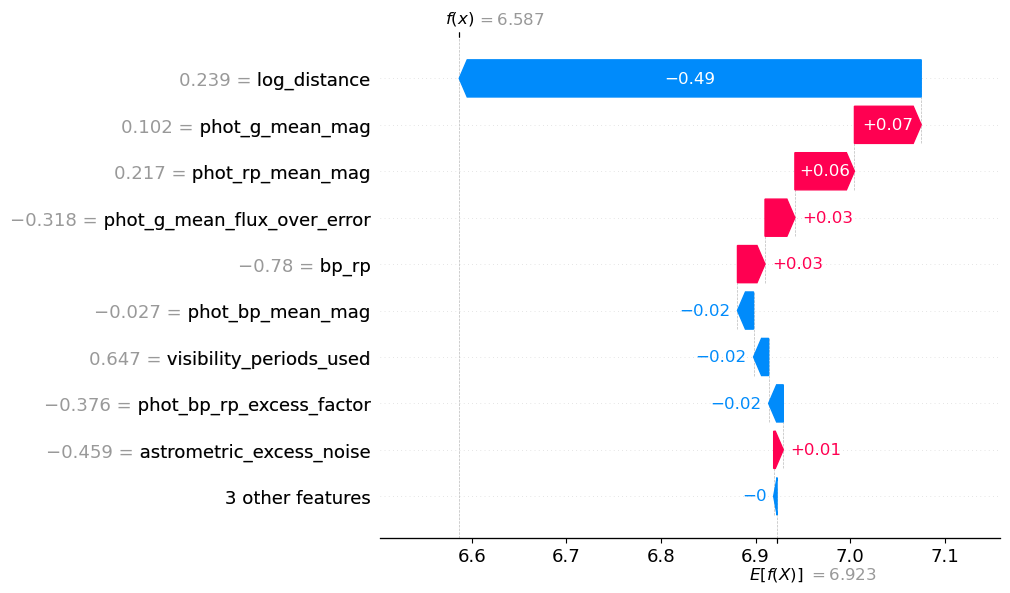

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(C=1, degree=2, gamma='scale', kernel='linear')
svr.fit(X_train_scaled, y_train)

explainer = shap.KernelExplainer(svr.predict, shap.sample(X_train_scaled, 100))
shap_values = explainer.shap_values(X_test_scaled)

# Waterfall Plot for a Single Prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_test_scaled[0], 
                                     feature_names=X_test.columns))

  0%|          | 0/26 [00:00<?, ?it/s]

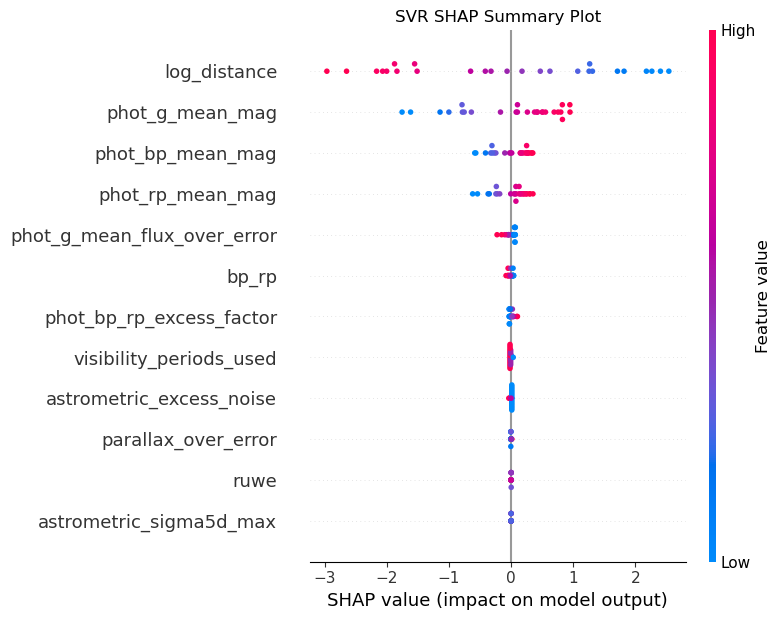

In [16]:
svr_best = SVR(C=1, degree=2, gamma='scale', kernel='linear')
svr_best.fit(X_train, y_train)

background = shap.sample(X_train, 50)
explainer = shap.KernelExplainer(svr_best.predict, background)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot (dot)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="dot", show=False)
plt.title("SVR SHAP Summary Plot")
plt.tight_layout()
plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

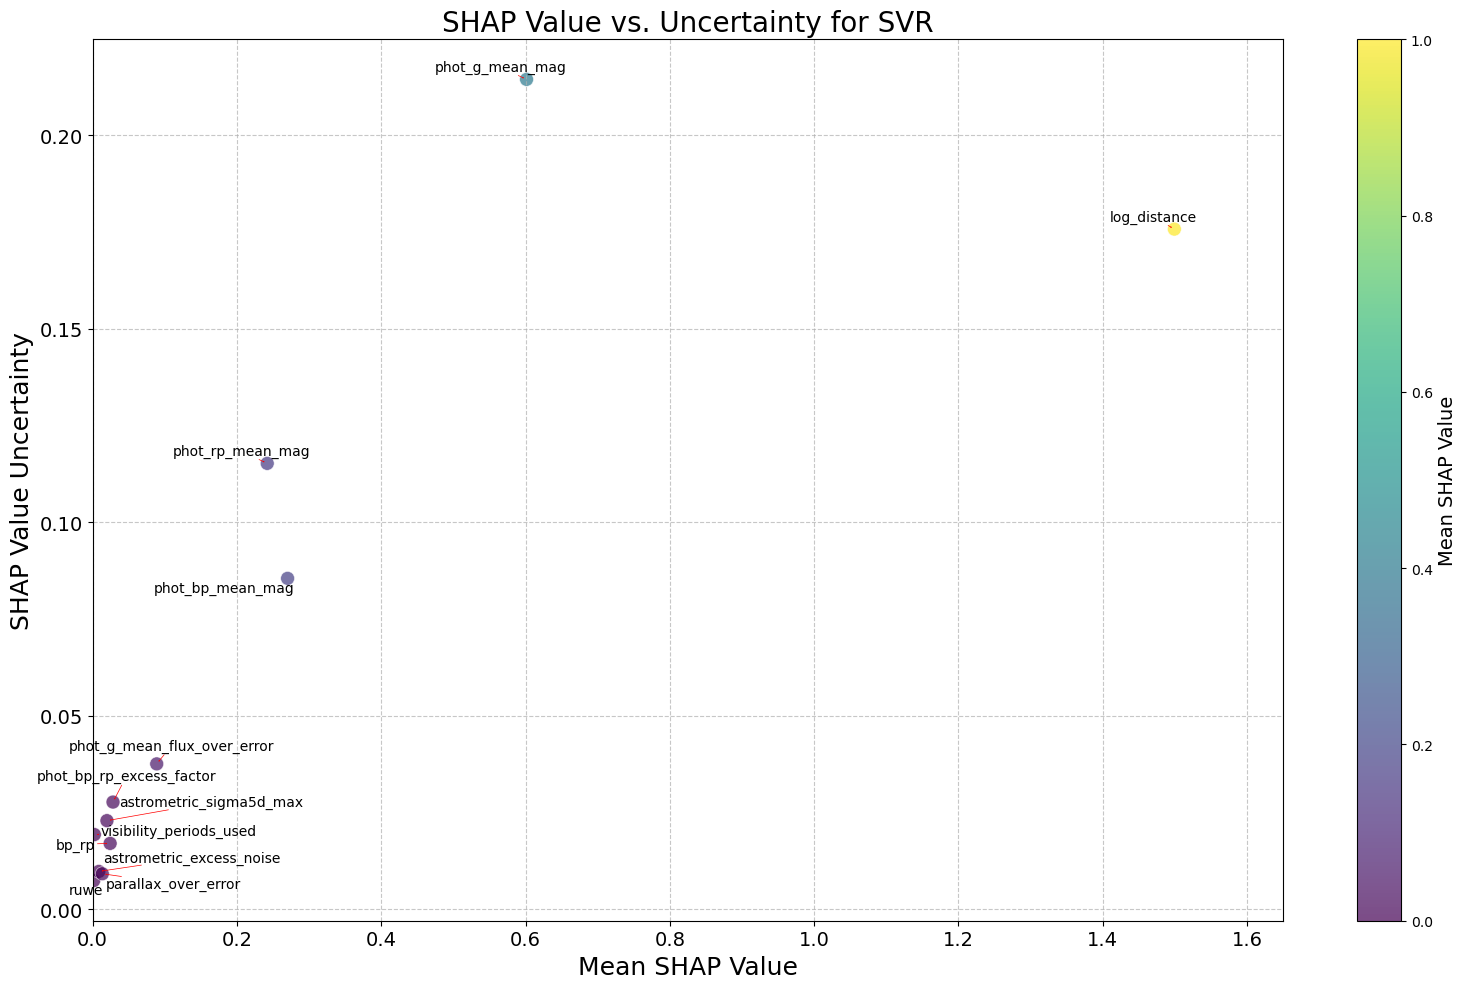

In [19]:
# Bootstrap shap values to estimate uncertainty.
def bootstrap_shap_values(model, X_train, X_test, y_train, n_samples=100):
    shap_values_samples = []
    for i in range(n_samples):
        X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
        model.fit(X_resampled, y_resampled)
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_resampled, 100))
        shap_values = explainer.shap_values(X_test)
        shap_values_samples.append(shap_values)
    return np.array(shap_values_samples)

shap_values_bootstrap = bootstrap_shap_values(best_model, X_train, X_test, y_train)
mean_shap_values = np.mean(shap_values_bootstrap, axis=0)
shap_value_uncertainty = np.std(shap_values_bootstrap, axis=0)
mean_abs_shap_values = np.mean(np.abs(mean_shap_values), axis=0)
mean_shap_value_uncertainty = np.mean(shap_value_uncertainty, axis=0)

plt.figure(figsize=(16, 10))

# Colormap based on absolute mean SHAP values
norm = plt.Normalize(vmin=min(mean_abs_shap_values), vmax=max(mean_abs_shap_values))
colors = plt.cm.viridis(norm(mean_abs_shap_values))

scatter = plt.scatter(mean_abs_shap_values, mean_shap_value_uncertainty, 
                      s=100, c=colors, alpha=0.7, edgecolors='w', linewidth=0.5)

plt.xlabel('Mean SHAP Value', fontsize=18)
plt.ylabel('SHAP Value Uncertainty', fontsize=18)
plt.title('SHAP Value vs. Uncertainty for SVR', fontsize=20)

texts = [plt.text(mean_abs_shap_values[i], mean_shap_value_uncertainty[i], 
                  txt, fontsize=10, ha='right', va='bottom')
         for i, txt in enumerate(X_test.columns)]

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Mean SHAP Value', fontsize=14)

plt.xlim(0, max(mean_abs_shap_values) * 1.1)

plt.tight_layout()
plt.show()

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

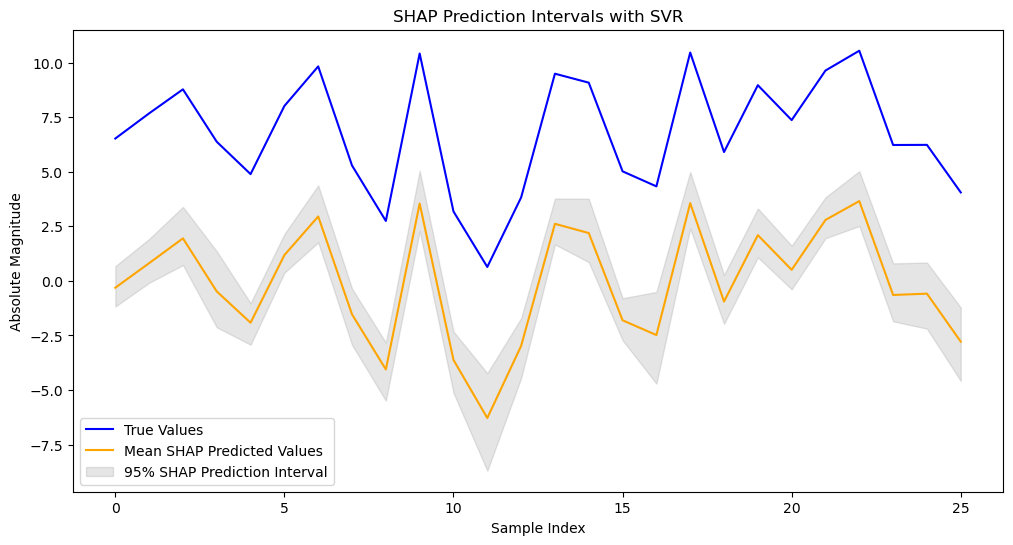

In [20]:
best_params = results['SupportVectorRegressor']['best_params']

n_bootstrap_samples = 100
n_test_samples = len(y_test)

bootstrap_shap_values = []

for i in range(n_bootstrap_samples):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    svr = SVR(**best_params)
    svr.fit(X_resampled, y_resampled)
    
    background = shap.sample(X_resampled, min(100, len(X_resampled)))
    
    explainer = shap.KernelExplainer(svr.predict, background)
    shap_values_resampled = explainer.shap_values(X_test)
    bootstrap_shap_values.append(shap_values_resampled)

bootstrap_shap_values = np.array(bootstrap_shap_values)

mean_shap_values = np.mean(bootstrap_shap_values, axis=0)
lower_bound_shap = np.percentile(bootstrap_shap_values, 2.5, axis=0)
upper_bound_shap = np.percentile(bootstrap_shap_values, 97.5, axis=0)

# SHAP Prediction Intervals
plt.figure(figsize=(12, 6))
plt.plot(range(n_test_samples), y_test, label='True Values', color='blue')
plt.plot(range(n_test_samples), mean_shap_values.sum(axis=1), label='Mean SHAP Predicted Values', color='orange')
plt.fill_between(range(n_test_samples), lower_bound_shap.sum(axis=1), upper_bound_shap.sum(axis=1), color='gray', alpha=0.2, label='95% SHAP Prediction Interval')
plt.xlabel("Sample Index")
plt.ylabel("Absolute Magnitude")
plt.title("SHAP Prediction Intervals with SVR")
plt.legend()
plt.show()